# Deploying ANN models on Google Coral USB Accelerator

<img src=" 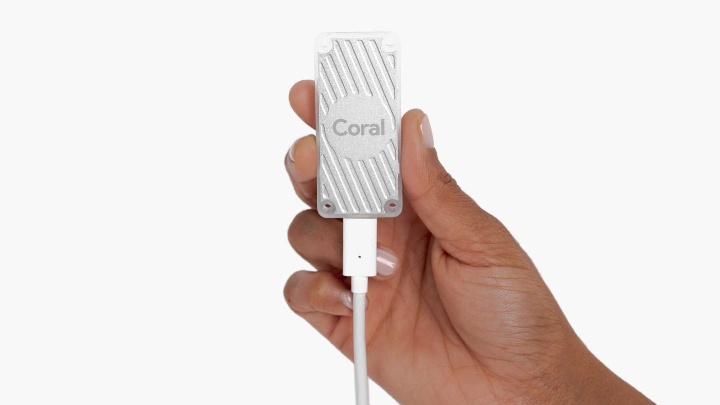" />

Google Coral USB Accelerator is a product designed for accelerating tensor operatons for ANN models. It is delivered in form of a small board that can be easly connected to PC or any other development board via USB cable.

The core of the Google CUA consists of Google Edge TPU (Tensor Processing Unit) 8-bit integer-based coprocessor said to be able to perform 4 TOPS (Trillion Operation Per Second) and 2 TOPS per 1 Watt. CUA is compatible with most of the Linux distributions, Windows, MacOS and also Raspbian OS. Models are executed using TensorFlow library and for other hardware-related operations, like input data loading, Google provides with pycoral Python library that implements all necessary tools for working with the device. 

## Model deployment on Google Coral USB Accelerator

In case you had some problems with loading model to device or conecting to it, try to unplug and plug in again the device and restart your notebook editor. Another option is to reinstall Edge TPU Runtime:

```
sudo apt-get --reinstall install libedgetpu1-std
```

In [ ]:
from pathlib import Path
import platform
import os
import time
import numpy as np
import cv2
import tensorflow as tf

from usb_accelerator_utils import draw_classification_results, run_program

In [ ]:
# @TODO: Set the shape of input data i.e. size of input image (it will be later used for input scaling)
INPUT_IMAGE_WIDTH  = ...
INPUT_IMAGE_HEIGHT = ...
print(f'Input  shape: ({INPUT_IMAGE_HEIGHT}, {INPUT_IMAGE_WIDTH})')

# @TODO: Load label names for MobilNet classes, you can find example files here: https://coral.ai/models/all/. Does labels' number equals model output shape?
LABELS = ...
print('Labels shape:', np.shape(LABELS))

Google Coral uses TensorFlow's [Lite Inference](https://www.tensorflow.org/lite/guide/inference) (tflite) format to run model. Before we will run the conversion tool, let's organize our workspace.

In [ ]:
# @TODO: Provide path to TF model that was saved previously
model_tf_dir = Path(...)

if not model_tf_dir.exists():
  raise FileNotFoundError(f'Cannot find model directory on given path: {model_tf_dir}')

# @TODO: Provide path to directory where the converison results will be stored
model_tflite_dir = Path(...)

model_tflite_dir.mkdir(parents=True, exist_ok=True)

# @TODO: Name your model :)
model_name = ...

# Full path to tflite representation file
model_tflite_path = Path(model_tflite_dir, model_name+'.tflite')

Now run the [model converter](https://www.tensorflow.org/lite/models/convert) to create tflite representation of our model. Because Google CUA uses 8-bit integers only, we need to perform quantization to int8, which requires providing the tool with representative dataset to calibrate new model. Such dataset should consist of example images that would be used for calssification (e.g. part of training dataset), but you can as well randomly generate samples (however it may have effect on calibration result). You can access original dataset from [this](https://image-net.org/) site or optionaly download smaller part of it (e.g. from [Kaggle](https://www.kaggle.com/datasets/ifigotin/imagenetmini-1000)).

In [ ]:
# @TODO: Implement representative dataset geenrator. Use special operator `yield` (https://www.geeksforgeeks.org/use-yield-keyword-instead-return-keyword-python/)
#        Remember to normalize input!
def representative_dataset():
  raise NotImplementedError('Generator for calibration dataset was NOT implemented!')

print('[ INFO ] Converting model to `tflite` format')
converter = tf.lite.TFLiteConverter.from_saved_model(str(model_tf_dir))

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.target_spec.supported_types = [tf.int8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model = converter.convert()

with open(f'{model_tflite_path}', 'wb') as f:
  f.write(tflite_model)
print(f'[ INFO ] Model saved to {model_tflite_path}')

Below are some helper functions used to load model on Google CUA and to retrieve results from it. They was taken and a little rewritten from `pycoral` library that you installed at the beginning of the laboratory. This is due to import conflicts as `TensorFlow` library, that delivers model converter used above, and `pycoral` library, that implements all necessary function to run program on Google CUA, both uses functionalities from `tflite_runtime` module, but imports them in different way (hence comflict arises).

In [ ]:
CORAL_EDGETPU_SHARED_LIB = {'Linux': 'libedgetpu.so.1', 'Windows': 'edgetpu.dll'}[platform.system()]

def coral_make_interpreter(model_path):
  """Create interpreter and load it to the device"""
  print('{[ DEBUG ] Make interpreter')
  return tf.lite.Interpreter(model_path=model_path, experimental_delegates=[tf.lite.experimental.load_delegate(CORAL_EDGETPU_SHARED_LIB, {})])

def coral_set_input_data(interpreter: tf.lite.Interpreter, data: np.ndarray):
  """Set data on input port"""
  input_details = interpreter.get_input_details()[0]
  tensor_index = input_details['index']
  scale, zero_point = input_details['quantization']
  interpreter.tensor(tensor_index)()[0][:,:] = np.uint8(data / scale + zero_point)

def coral_get_scores(interpreter):
  """Get inference results"""
  output_details = interpreter.get_output_details()[0]
  output_data = interpreter.tensor(output_details['index'])().flatten()
  scale, zero_point = output_details['quantization']
  output_data = scale * (output_data.astype(np.int64) - zero_point)
  return output_data.copy()

Having model as tflite file the last step before running our app is to convert it to more TPU-oriented format. [Here](https://coral.ai/docs/edgetpu/compiler/) is guide how to perform it locally and [here](https://colab.research.google.com/github/google-coral/tutorials/blob/master/compile_for_edgetpu.ipynb) is Colab notebook that allows you to convert your model online. If you managed to install google's `edge_tpu` compiler, run below command. Otherwise, you need to use mentioned online notebook.

In [ ]:
!edgetpu_compiler --out_dir {model_tflite_dir} {model_tflite_path}

Now load the model and allocate necessary resources.

In [ ]:
# @TODO: Create new interpreter using earlier defined functions. Remember to use tflite model converted by `edgetpu_compiler`
interpreter = ...

interpreter.allocate_tensors()
if interpreter.get_input_details()[0]['dtype'] != np.uint8:
  raise ValueError('Device only supports `uint8` input type')

The core of our application is different basing on hardware we use. Below function is used for executing model in tflite format on Google Coral USB Accelerator.

In [ ]:
def run_cua_classification(interpreter: tf.lite.Interpreter, img: np.ndarray, max_classes: int=1, min_score: float=0.0) -> float:
  
  # @TODO: Prepare image so it fits into model input.
  input_img = ...
  
  t0 = time.perf_counter()
  
  # @TODO: perform one inference on prepared data. Use earlier defined functions
  #        Hint 1: https://www.tensorflow.org/api_docs/python/tf/lite/Interpreter
  #        Hint 2: https://studymachinelearning.com/introduction-to-tensorflow-lite/
  result = ...
  
  elapsed = time.perf_counter() - t0
  
  # @TODO: Extract classification scores, make it as a one-dimensional array
  scores = ...
  
  class_idxs = np.arange(start=0, stop=scores.shape[0], step=1, dtype=int)
  draw_classification_results(
    img=img,
    class_idxs=class_idxs,
    scores=scores,
    labels=LABELS,
    max_classes=max_classes,
    min_score=min_score)
  return elapsed

Finally run the application.

In [ ]:
run_program(
  exec_net=interpreter,
  c_func=run_cua_classification,
  camera_idx=0,
  max_disp=3,
  min_score=0.1)